## Initializing weights Part 2

<img src="balance.jpg" alt="Diagram of a balance" width="250">

This blog will teach us about Layer-wise Sequential Unit-Variance (LSUV), layer normalization, and batch normalization. This blog is based on [lesson 17](https://course.fast.ai/Lessons/lesson17.html) of the FastAI course.

LSUV is a straightforward technique for initializing weights. Layer norm and batch norm do not initialize weights before the training, but they help the model train by modifying the statistics of the weights.

First, we import libraries and do required setups.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'

!pip -q install torcheval
!pip -q install datasets

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.xtras import *

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.5 MB/s eta 0:00:00


Just like the last time, we will use pytorch datasets. But this time, we will normalize the dataset before we create the dataloaders.

In [ ]:
xmean, xstd = (tensor(0.29), tensor(0.35))

In [ ]:
def batch_tfm(img): return (ToTensor()(img) - xmean) / xstd

In [ ]:
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

trn_ds = datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=batch_tfm
)

val_ds = datasets.FashionMNIST(
    root=".",
    train=False,
    download=True,
    transform=batch_tfm
)

In [ ]:
from torch.utils.data import DataLoader
set_seed(42)
bs = 1024

trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [ ]:
xb.mean(), xb.std()

(tensor(-0.01), tensor(1.01))

In [ ]:
class GeneralRelu(nn.Module):
    def __init__(self, leaky=None, sub=0., max_val=None):
        super().__init__()
        self.relu = nn.ReLU() if leaky is None else nn.LeakyReLU(leaky)
        self.sub = sub
        self.max_val = max_val

    def forward(self, x):
        x = self.relu(x)
        x -= self.sub
        if self.max_val is not None:
            x.clamp_max_(self.max_val)
        return x

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=None):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act is not None: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, filters=None):
    if filters is None: filters = [1, 8, 16, 32, 64]
    layers = [conv(filters[i], filters[i+1], act=act) for i in range(len(filters)-1)]
    return nn.Sequential(*layers, conv(filters[-1], 10, act=None), nn.Flatten()).to(def_device)

## LSUV (layer-sequential unit variance)

LSUV came from [All you need is a good init](https://arxiv.org/pdf/1511.06422.pdf). This has a very complicated name, but it is a straightforward idea. The good thing about this paper is that it does not have complicated math like other papers, so it is suitable for beginners to read. Simply put, regardless of what kind of activation layer we use, we can initialize weights correctly for training. Here, initializing correctly means making a mean of zero and a standard deviation of one, which allows us to train fast.

For different activation layers, we have to use variety of initialization techniques. For instance, when using relu, we use kaiming initialization, and if there is no activation layer, we can just use Xavier init. Instead of using different activation methods for them, we can just use LSUV to initialize the weights. Let's look at the pseudo code from the paper and create it ourselves.

Here is the pseudo code from the paper:
```
Pre-initialize network with orthonormal matrices as in Saxe et al. (2014)
for each layer L do
    while |Var(BL) − 1.0| ≥ Tolvar and (Ti < Tmax) do
        do Forward pass with a mini-batch
        calculate Var(BL)
        WL = WL / sqrt(Var(BL))
    end while
end for
```
- `L` is convolution or full-connected layer
- `Var(x)` takes variance of input x.
- `BL` is output blob from `L`.
- `Tolvar` is variance tolerance
- `Ti` is current trial. Incremented every loop.
- `Tmax` is max trial
- `WL` is weights
- `sqrt(x)` takes square root of input x.

According to the paper, we call the model on a batch of data to find the standard deviation of the weights. Then, we divide the weight by the standard deviation to set them closer to 1. If it is not close enough, we repeat the process until it is within our tolerance, `Tolvar`. We also increment `Ti` in each loop, and if it reaches `Tmax`, we stop the loop. However, in practice, it never reached Tmax. That's it. Let's implement it ourselves.

In [ ]:
set_seed(1)
gr = partial(GeneralRelu, .2, .4)
model = get_model(gr)
metrics = MetricsCB(accuracy=MulticlassAccuracy(device='cpu'))
astats = ActivationStats(mod_filter=fc.risinstance(GeneralRelu), plot=True)
cbs = [metrics, astats, DeviceCB(), ProgressCB()]

To get the statistics of the data, we use Pytorch hooks. For our initialization function, we take `act` for the activation function and `conv` for convolutional layers. So, we calculate statistics from `act` output and update `conv` weights. After initialization, we remove hooks to clean up.

In [ ]:
def good_init_hook(hook, m, inp, outp):
    x = to_cpu(outp)
    hook.mean, hook.std = x.mean(), x.std()

In [ ]:
def good_init_no_bias(model, act, conv, xb, tol=1e-2):
    h = Hook(act, good_init_hook)
    with torch.no_grad():
        model(xb)
        while abs(h.std - 1.0) > tol:
            model(xb)
            conv.weight.data /= h.std
    h.remove()

In [ ]:
grs = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [ ]:
for m, m_in in zip(grs, convs):
    good_init_no_bias(model, m, m_in, xb, tol=0.001)

accuracy,loss,epoch,train,time
0.781,0.612,0,True,00:17
0.844,0.437,0,False,00:02
0.865,0.369,1,True,00:16
0.863,0.374,1,False,00:01


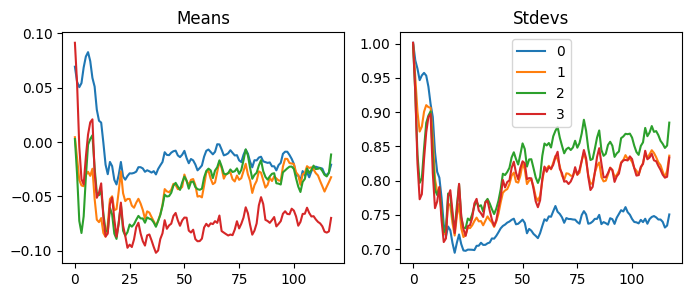

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

However, we can also set the mean of the weights to zero like [lesson 17](https://course.fast.ai/Lessons/lesson17.html) of FastAI.

In [ ]:
set_seed(1)
model = get_model(gr)

In [ ]:
def good_init(model, act, conv, xb, tol=1e-3):
    h = Hook(act, good_init_hook)
    with torch.no_grad():
        model(xb)
        while abs(h.std - 1.0) > tol and abs(h.mean) > tol:
            model(xb)
            conv.weight.data /= h.std
            conv.bias.data -= h.mean
    h.remove()

In [ ]:
grs = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
grs, convs

([GeneralRelu(
    (relu): LeakyReLU(negative_slope=0.2)
  ),
  GeneralRelu(
    (relu): LeakyReLU(negative_slope=0.2)
  ),
  GeneralRelu(
    (relu): LeakyReLU(negative_slope=0.2)
  ),
  GeneralRelu(
    (relu): LeakyReLU(negative_slope=0.2)
  )],
 [Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
  Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))])

In [ ]:
convs[0].weight.std(), convs[0].bias

(tensor(0.18, grad_fn=<StdBackward0>),
 Parameter containing:
 tensor([ 0.16,  0.02,  0.11,  0.07,  0.12,  0.17, -0.31,  0.17], requires_grad=True))

In [ ]:
for m, m_in in zip(grs, convs):
    good_init(model, m, m_in, xb, tol=0.001)

In [ ]:
convs[0].weight.std(), convs[0].bias

(tensor(0.65, grad_fn=<StdBackward0>),
 Parameter containing:
 tensor([ 0.03, -0.11, -0.02, -0.05, -0.01,  0.04, -0.44,  0.04], requires_grad=True))

accuracy,loss,epoch,train,time
0.783,0.607,0,True,00:17
0.843,0.438,0,False,00:02
0.865,0.368,1,True,00:18
0.865,0.371,1,False,00:01


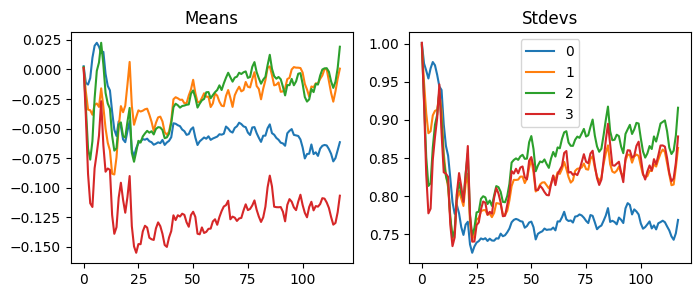

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

The initialization worked, and our model trained well. However, it requires many lines of code. So, let's create a callback! Because we only want to fit once, we track whether the model's been fitted. We also have an option to initialize bias or not. We do not need bias when we use batch normalization or layer normalization later.

In [ ]:
class LSUVCB(Callback):
    def __init__(self, bias=True):
        self.fit_ = False
        self.bias = bias

    def before_fit(self, learn):
        if not self.fit_:
            self.fit_ = True
            model = learn.model
            grs = [o for o in model.modules() if isinstance(o, GeneralRelu)]
            convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]
            for m, m_in in zip(grs, convs):
                init = good_init if self.bias else good_init_no_bias
                init(model, m, m_in, xb, tol=0.001)

accuracy,loss,epoch,train,time
0.783,0.607,0,True,00:16
0.843,0.438,0,False,00:01
0.865,0.368,1,True,00:17
0.865,0.371,1,False,00:01


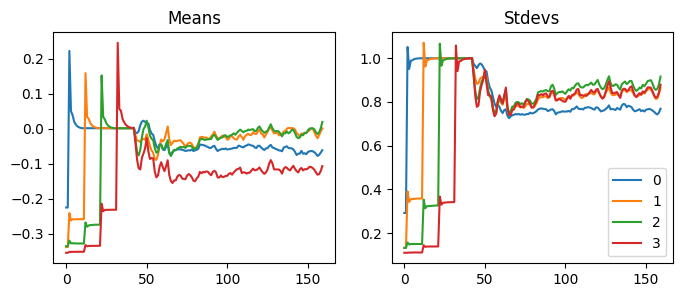

In [ ]:
set_seed(1)
model = get_model(gr)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=.2, cbs=cbs+[LSUVCB()])
learn.fit(2)

With our `LSUVCB`, we can do the same thing very easily. When we look at the statistics of the activations, we can see the activations move to the mean of zero and the standard deviation of one.

## Layer Normalization

Before we start looking at batch normalization, we will look at layer norm, a simpler version of batch norm. [Layer Normalization](https://arxiv.org/abs/1607.06450) by Jimmy Lei Ba, Jamie Ryan Kiros, and Geoffrey E. Hinton is math-heavy and challenging to understand. However, the code is straightforward.

Although batch norm performs very well, it has a couple of limitations. It was computationally expensive, cannot be used for recurrent neural networks, and cannot have models with small batch sizes. To fix these issues, layer norm uses fewer parameters to train with a more straightforward design.

What does `LayerNorm` do? It has learnable parameters, `self.mult` and `self.add`. For each batch, it calculates means and standard deviations over the channels, heights, and weights for each batch size. Then, we normalize the weights to a mean of zero and a standard deviation of one. However, this might not be the ideal place for the the weights for training. That's where `self.mult` and `self.add` come in to shift the weights to better places. To define new parameters in Pytorch, we use `nn.Parameter`.

We also take `eps` as a parameter. This prevents weights from getting too big when the standard deviation gets too low. `dummy` parameter does not do anything here, but it will be used for batch norm.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps = 1e-4):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))

    def forward(self, x):
        mean = x.mean((1,2,3), keepdim=True)  # NCHW
        std  = x.std((1,2,3), keepdim=True)
        x = (x - mean) / (std+self.eps).sqrt()
        return (x * self.mult) + self.add

To use `LayerNorm` and `BatchNorm`, we must slightly modify the `conv`. It takes `norm` and `bias` parameters because these techniques do not need bias because we normalize each batch using `self.mult` and `self.add`. Basically, `self.add` acts as bias.

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=None, norm=None, bias=None):
    if bias is None: bias = isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    res = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm is not None: res.append(norm(nf))
    if act is not None: res.append(act())
    return nn.Sequential(*res)

In [ ]:
def get_model(act=nn.ReLU, norm=None, filters=None):
    if filters is None: filters = [1, 8, 16, 32, 64]
    layers = [conv(filters[i], filters[i+1], act=act, norm=norm) for i in range(len(filters)-1)]
    return nn.Sequential(*layers, conv(filters[-1], 10, act=None), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train,time
0.711,0.831,0,True,00:21
0.817,0.499,0,False,00:02
0.841,0.439,1,True,00:20
0.847,0.428,1,False,00:02
0.864,0.377,2,True,00:22
0.847,0.411,2,False,00:02
0.876,0.340,3,True,00:21
0.868,0.358,3,False,00:02
0.882,0.320,4,True,00:20
0.870,0.353,4,False,00:02


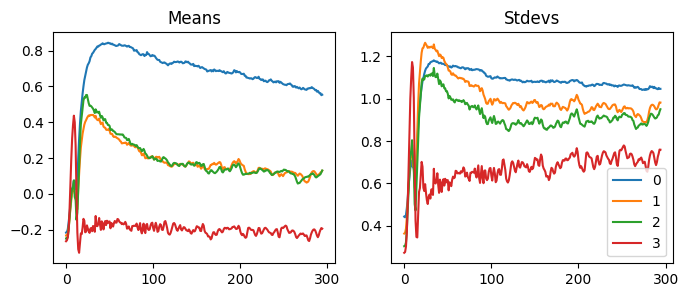

In [ ]:
set_seed(1)
model = get_model(gr, norm=LayerNorm)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=.2, cbs=cbs)
learn.fit(5)

I wondered what would happen if I take means and standard deviations like how we would do in batch norm, and it performed better.

In [ ]:
class MyNorm(nn.Module):
    def __init__(self, dummy, eps = 1e-4):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))

    def forward(self, x):
        mean = x.mean((0,2,3), keepdim=True)  # NCHW
        std  = x.std((0,2,3), keepdim=True)
        x = (x - mean) / (std+self.eps).sqrt()
        return (x * self.mult) + self.add

accuracy,loss,epoch,train,time
0.747,0.739,0,True,00:22
0.832,0.459,0,False,00:02
0.860,0.388,1,True,00:21
0.857,0.392,1,False,00:02
0.875,0.340,2,True,00:23
0.866,0.358,2,False,00:02
0.888,0.306,3,True,00:23
0.876,0.335,3,False,00:02
0.893,0.286,4,True,00:23
0.883,0.318,4,False,00:02


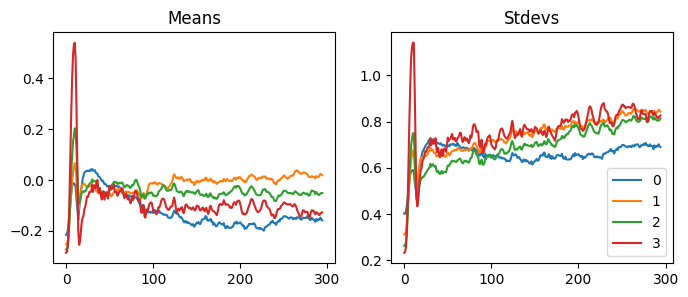

In [ ]:
set_seed(1)
model = get_model(gr, norm=MyNorm)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=.2, cbs=cbs)
learn.fit(5)

We did not initialize the weights before training. However, layer norm normalizes every batch, so it is optional. But let's try initializing the weights before we train.

In [ ]:
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weights, a=leaky)

In [ ]:
iw = partial(init_weights, .2)

accuracy,loss,epoch,train,time
0.785,0.595,0,True,00:15
0.848,0.415,0,False,00:01
0.867,0.361,1,True,00:15
0.863,0.367,1,False,00:01


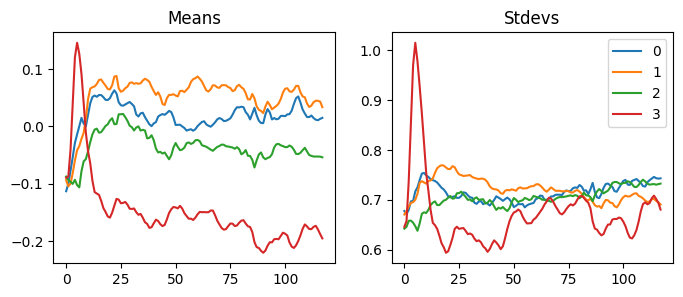

In [ ]:
set_seed(1)
model = get_model(gr, norm=LayerNorm)
learn = MomentumLearner(model.apply(iw), dls, F.cross_entropy, lr=.2, cbs=cbs)
learn.fit(2)

There is little difference between initializing or not, at least in this case.

## Batch Normalization

Batch norm emerged in [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167). This paper is more challenging to read than "All You Need Is Good Init" but can still be understood. Math can be confusing, but it has pseudo code for algorithms, which is easier to read. For an easier version of the paper with diagrams, take a look at [a medium article](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739).

I think this paper is awesome how the authors thought covariate shift was the problem of training and found a way to manage it. They normalized each batch, which helped the model to train. It also had learnable parameters that can shift and scale the distribution to more easily trainable distribution.

We can think of the neural net as a chef and the transformation as a server. A chef can take orders, cook, and serve at the same time if the restaurant is not busy. However, as more customers come in, a server can help so that the chef can focus on cooking. Instead of the neural nets to find magic parameters for the minimum loss, we help them with finding the best distribution for the weights using those learnable parameters.

However, batch norm makes training epochs slower. Also, this is quite a complicated algorithm with learnable parameters and has more complex inference as we will see later.

### More in depth of the paper:

Those who want to skip this part can still understand its importance and the code without learning the underlying math. However, we will dig into some math and equations for those who are curious.

The paper defines `Internal Covariate Shift` as the change in the distributions of internal nodes of a deep network during training. Why is this a problem? To train fast, the inputs of each layer have to have zero means and unit variances without correlation according to [Efficient Backprop](https://cseweb.ucsd.edu/classes/wi08/cse253/Handouts/lecun-98b.pdf) by LeCun et al. However, when we train, statistics of the inputs change due to updating parameters.

First thing the authors tried to fix this issue is to update the statistics after the stochastic gradient descent step to train by normalization. However, the bias grew too much because the optimization did not know about the normalization. So, the normalization had to be part of the gradient step process.

So, they suggested using the whole data to normalize. However, this is too expensive, so they use mini-batch statistics assuming these represent statistics for the whole data.

The paper says, a layer with d-dimensional input $\mathbf{x}=(x^{(1)}\ldots x^{(d)})$, we normalize each dimension

$$ \hat{x}^{(k)} = \frac{x^{(k)}-\operatorname {E}[x^{(k)}]}{\sqrt{\operatorname {Var}[x^{(k)}]}} \tag{1} $$

where $\operatorname {E}[x^{(k)}]$ is expected value and $\operatorname {Var}[x^{(k)}]$ is variance over the training data set. The expected value is an average, and there is more information on [wikipedia](https://en.wikipedia.org/wiki/Expected_value).

Then, we apply the transformation to each dimension:

$$y^{(k)} = \gamma^{(k)}\hat{x} + \beta^{(k)} \tag{2} $$

where $\gamma^{(k)}$ (gamma) and $\beta^{(k)}$ (beta) are learnable parameters.

Let's look at the normalizing part of Algorithm 1. This looks familiar:

$$ \hat{x}_i \leftarrow \frac{x_i-\operatorname \mu_B}{\sqrt{\sigma^2_B+\epsilon}} \tag{3}$$


 This is almost the same thing as equation `(1)`. For this one, we omit (k) for simplicity and readability. Instead of using $\operatorname {E}$ or $\operatorname {Var}$, we use Greek letters here for some reason. $\mu_B$ (mu) represents an average over the batch, $\sigma^{2}_B$ (sigma) is a variance over the batch. $\epsilon$ (epsilon) is used for numerical stability just in case our variance gets too small. After normalization, we scale and shift using the equation `(2)`.

Now, let's move on to Algorithm 2 in section 3.1. This section is all about inference. For inference, we use the population (the whole thing) instead of using batches to calculate means and variances. We use [moving averages](https://en.wikipedia.org/wiki/Moving_average) to calculate these.

In Algorithm 2, the first part is training, and the second is inference. Although number 10 says, "process multiple training mini-batches $B$, ..." we calculate these during the training. The last step was a bit confusing to me when I first encountered this:

$$ y = \frac{\gamma}{\sqrt{\operatorname{Var}[x]+\epsilon}}\cdot x + (\beta - \frac{\gamma\operatorname{E}[x]}{\sqrt{\operatorname{Var}[x]+\epsilon}}) \tag{4}$$

This is the same as the normalization step combined with scale and shift in Algorithm 1. We can rewrite equation `(4)` as the following:

$$ y=\gamma(\frac{x-\operatorname{E}[x]}{\sqrt{\operatorname{Var}[x]+\epsilon}}) + \beta \tag{5}$$

It's more clear this way.

### Batch norm code

That's it. Now let's take a look at the code from FastAI course:

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))             # Used for both training and inference (gamma)
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))             # Used for both training and inference (beta)
        self.register_buffer('vars',  torch.ones(1,nf,1,1))        # Only used for inference (Var[x])
        self.register_buffer('means', torch.zeros(1,nf,1,1))       # Only used for inference (E[x])

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)  # NCHW
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)                              # Weighted average
        self.vars.lerp_ (v, self.mom)
        return m,v

    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

The `update_stats` method calculates means and variances over channels/features of the convolutional layer. This is because we want the same feature map to be normalized similarly. This is also where the moving average takes place to save `vars` and `means`.

Technically, batch and layer norms do not need initialization because the layers are normalized in each batch/epoch. These also normalize layers, so they do not need as much normalization as others. We will learn about different normalization techniques later, but these are techniques that prevent the models from overfitting.

Batch normalization also allows us to use a higher learning rate.

accuracy,loss,epoch,train,time
0.762,0.653,0,True,00:22
0.829,0.480,0,False,00:02
0.850,0.415,1,True,00:21
0.849,0.425,1,False,00:01
0.866,0.368,2,True,00:22
0.852,0.404,2,False,00:02
0.877,0.338,3,True,00:20
0.858,0.384,3,False,00:02
0.884,0.315,4,True,00:20
0.870,0.355,4,False,00:01


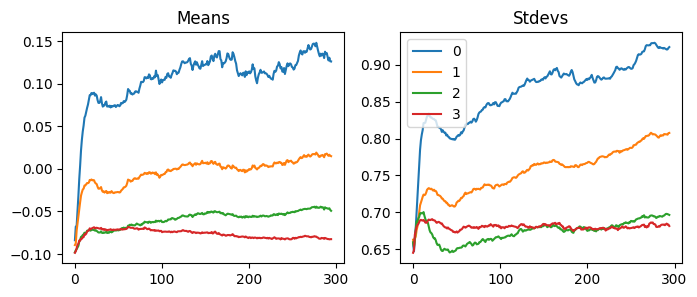

In [ ]:
set_seed(1)
# model = get_model(gr, norm=BatchNorm).apply(iw)
model = get_model(gr, norm=BatchNorm)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(5)

Pros and cons of batch norm:

Pros:
- Higher learning rate.
- Regularization.
- Less epochs for better results.

Cons:
- Slower training.
- Cannot be used for RNN.
- Cannot use very small batch sizes.

## Conclusion

This blog taught us about LSUV, layer norm, and batch norm. They are all similar to each other. LSUV normalizes before training, and others normalize each batch. Layer norm is a simpler version of batch norm. We also dug deeper into the papers. The batch norm is widely used, and reading the paper will benefit the deep learning journey.

Reading papers is difficult, but it is a helpful skill to learn new things. It may be challenging at first and perhaps impossible depending on which paper or what prerequisite readers have, but it will be easier to read.